# COVID-19 Research Paper K-Means Clustering

Create clusters in the data using the abstracts of each paper, using the K-means clustering algorithm.


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
from nltk.stem.snowball import SnowballStemmer

import re

In [47]:
"""Convert metadata.csv to a df_abstracts, which contains the sha and abstracts of every valid paper.
-read in metadata.csv to a df
-filter out rows without a full text file
-filter out rows with multiple corresponding full text files
-create df_abstracts, which contains sha and abstracts for all valid papers
"""

df = pd.read_csv("CORD-19-research-challenge/metadata.csv")
df_with_full = df.loc[df['has_full_text'] == True].drop(columns = 'has_full_text')

df_custom_license = df_with_full.loc[df_with_full['full_text_file'].str.match("custom_license")]
df_noncomm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("noncomm_use_subset")]
df_comm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("comm_use_subset")]
df_biorxiv_medrxiv = df_with_full.loc[df_with_full['full_text_file'].str.match("biorxiv_medrxiv")]

invalid_rows = []
for index, row in df_custom_license.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)

df_custom_license = df_custom_license.drop(invalid_rows)

invalid_rows = []
for index, row in df_noncomm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_noncomm_use_subset = df_noncomm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_comm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_comm_use_subset = df_comm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_biorxiv_medrxiv.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_biorxiv_medrxiv = df_biorxiv_medrxiv.drop(invalid_rows)

df_all = pd.concat([df_custom_license, df_noncomm_use_subset, df_comm_use_subset, df_biorxiv_medrxiv])

df_abstracts = df_all[['sha','abstract']]

df_abstracts.to_csv("abstracts.csv")

In [48]:
"""Take sample of rows from df_abstracts to reduce runtime"""

df_abstracts_partial = df_abstracts.sample(n=10000)
df_abstracts_partial = df_abstracts_partial.dropna()

In [49]:
"""Remove rows with bad input in abstract column"""

abstract_list = df_abstracts_partial["abstract"].values
abstract_list = [x for x in abstract_list if str(x) != 'nan']
type(abstract_list)

list

In [50]:
"""Check to make sure all abstract values are strings"""

bad_inputs = 0
for i in abstract_list:
    if type(i) != str:
        bad_inputs += 1
bad_inputs

0

In [51]:
""" Takes in abstract_list, returns abstract_list_stemmed, which contains the same list
of strings but with each word converted to reduce variability
"""

snowBallStemmer = SnowballStemmer("english")

abstract_list_stemmed = []

# adapted from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [snowBallStemmer.stem(word) for word in words]
    return words

for i in abstract_list:
    words_list = stemming_tokenizer(i)
    words_paragraph = ""
    for j in words_list:
        words_paragraph = words_paragraph + " " + j
    abstract_list_stemmed.append(words_paragraph)

In [52]:
"""Creares a df of TFIDF vectorized abstracts

TF-IDF (term frequency-inverse document frequency) is a statistical
measure that evaluates how relevant a word is to a document in a collection.

adapted from https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

token_pattern=r'(?u)\b[A-Za-z]+\b' filters out non-alphabetical characters
"""

vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.95, max_features = 150, stop_words = 'english', token_pattern=r'(?u)\b[A-Za-z]+\b')
vectors = vectorizer.fit_transform(abstract_list_stemmed)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [53]:
df

,abstract,acid,activ,acut,addit,age,agent,analysi,anim,antibodi,...,test,time,transmiss,treatment,type,use,vaccin,viral,virus,year
0,0.000000,0.0,0.000000,0.000000,0.000000,0.063745,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.056645,0.032711,0.000000,0.165374,0.259602,0.055825
1,0.000000,0.0,0.074562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.025218,0.000000,0.095621,0.125087,0.000000
2,0.000000,0.0,0.000000,0.109968,0.000000,0.194053,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.054756,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283236
3,0.055098,0.0,0.000000,0.082172,0.166574,0.000000,0.000000,0.077096,0.178540,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.099211,0.000000,0.062697,0.147631,0.000000
4,0.000000,0.0,0.000000,0.186302,0.000000,0.000000,0.000000,0.174794,0.000000,0.000000,...,0.090537,0.000000,0.0,0.000000,0.000000,0.056233,0.000000,0.000000,0.000000,0.095969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8703,0.049846,0.0,0.265373,0.074339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.077669,0.000000,0.000000,0.000000,0.056721,0.089039,0.000000
8704,0.042992,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073157,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.868146,0.000000,0.000000,0.000000
8705,0.078932,0.0,0.105056,0.000000,0.000000,0.000000,0.267805,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.179637,0.070498,0.000000
8706,0.000000,0.0,0.000000,0.031342,0.031767,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.075682,0.000000,0.047828,0.244009,0.000000


In [54]:
"""100 most relevant features"""

(df.columns)

Index(['abstract', 'acid', 'activ', 'acut', 'addit', 'age', 'agent', 'analysi',
       'anim', 'antibodi',
       ...
       'test', 'time', 'transmiss', 'treatment', 'type', 'use', 'vaccin',
       'viral', 'virus', 'year'],
      dtype='object', length=150)

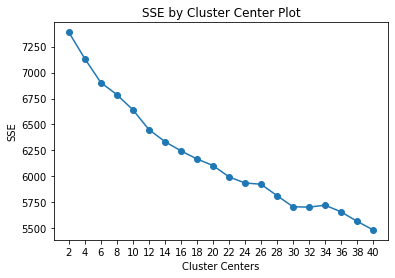

In [55]:
"""Creates an elbow plot to identify the ideal number of clusters based on sum of squared errors

copied from https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
"""

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        #print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(df, 40)

In [56]:
"""Displays an example of the TFIDF vector for a single paper"""

row_dict = df.loc[ 0 , : ].to_dict()

from collections import OrderedDict

dd = OrderedDict(sorted(row_dict.items(), key=lambda x: x[1], reverse=True))
dd

OrderedDict([('pneumonia', 0.6580116228373272),
             ('respiratori', 0.3646678559977498),
             ('virus', 0.25960227894247506),
             ('patient', 0.25490558673758845),
             ('detect', 0.24241171178019072),
             ('sever', 0.1751636868661802),
             ('viral', 0.1653740029139932),
             ('day', 0.12412072995574065),
             ('rate', 0.11978189153563867),
             ('influenza', 0.11527514711971464),
             ('case', 0.10604050861873779),
             ('increas', 0.09512975099997341),
             ('caus', 0.09465517162518916),
             ('import', 0.09378114427243181),
             ('signific', 0.09229416883054485),
             ('includ', 0.08895830398128438),
             ('studi', 0.06642895310384536),
             ('infect', 0.06580282871160935),
             ('b', 0.06498371200303843),
             ('hospit', 0.06429372309904739),
             ('age', 0.06374527537839919),
             ('p', 0.06316671931334869),
   

In [57]:
"""Adds assigned cluster cloumn to df_partial_abstracts."""

clusters = MiniBatchKMeans(n_clusters=15, init_size=1024, batch_size=2048, random_state=20).fit_predict(df)

df_abstracts_partial["cluster"] = clusters
df_abstracts_partial.sort_values("cluster")

,sha,abstract,cluster
25568,850295bc1049a0609b4568610f3b27bf9a150878,Pneumonia severity index (PSI) is an important...,0
22916,1efd8ee0124faf388961ff309a10ca2cfba5268c,BACKGROUND: There are very limited data on chi...,0
12907,b5d3dcdd7bb6d2db32c7318796ac7272f2229701,Résumé Objectif Comparer les caractéristiques ...,0
11649,f1c6619cfe09dd221c629b09f36cca5bc5f8ae67,Resumen En este protocolo expondremos los paso...,0
17213,1d014d12e44c800bcc53665d422eb4b4881fef79,Antecedentes El metapneumovirus humano es un v...,0
...,...,...,...
15699,1a80ce2336e72d0e9283afaf12e5d25255f4984e,Abstract Severe acute respiratory syndrome (SA...,14
41732,577c6a13f9ef70e9756890fc66e98f537c01ac0a,The emergence of Middle East respiratory syndr...,14
43369,b5094dcef4e616a20092ca5e3a30d0e9369455fd,Novel coronavirus (SARS-CoV-2) is found to cau...,14
18236,804a9591280b7f64fa79cd3e4a9358976b084ffb,A possible threat in the ophthalmology clinic ...,14


In [58]:
clustercounts = df_abstracts_partial[["abstract", "cluster"]]
clustercounts = clustercounts.groupby("cluster", as_index=False).count().sort_values("abstract", ascending=False)
clustercounts

,cluster,abstract
1,1,1418
4,4,778
2,2,746
8,8,691
0,0,645
13,13,611
11,11,557
3,3,540
7,7,513
9,9,482


<function matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs)>

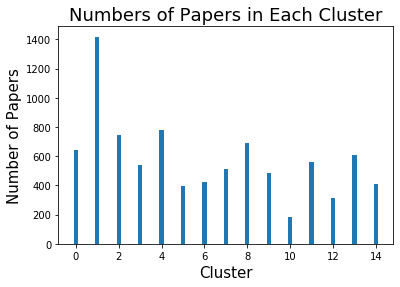

In [63]:
# plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('cluster', 'abstract', data=clustercounts)
plt.xlabel("Cluster", size=15)
plt.ylabel("Number of Papers", size=15)
plt.title("Numbers of Papers in Each Cluster", size=18)
plt.xticks
# plt.savefig("hello.png")

In [78]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(df, clusters)

TypeError: '(array([7833, 8642, 8398, ...,  518, 4973, 6022]),)' is an invalid key

In [69]:
range(df.shape[0])

range(0, 8672)